In [79]:
#Aumentar en un 2% el acceso al servicio de internet para el próximo trimestre, cada 100 hogares, por provincia. La fórmula es la siguiente:

In [163]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine,Table, Column, Integer, String, Float, MetaData
from dotenv import load_dotenv
import os
from helper import Funciones

In [81]:
import warnings
warnings.filterwarnings('ignore')

In [133]:
fun= Funciones('conexion.env')

In [134]:
engine = fun.crear_conexion_mysql()
df = pd.read_sql_table('internet_penetracion_hogares', con=engine)

In [84]:
df.columns

Index(['idTabla', 'año', 'trimestre', 'provincia', 'accesosPor100Hogares'], dtype='object')

In [135]:
# Ordenar el DataFrame por provincia y trimestre
df = df.sort_values(by=['provincia', 'año','trimestre'])

# Calcular el acceso del trimestre anterior usando shift
df['accesos_trimestre_anterior'] = df.groupby(['provincia'])['accesosPor100Hogares'].shift(1)

In [86]:
df

,idTabla,año,trimestre,provincia,accesosPor100Hogares,accesos_trimestre_anterior
936,937,2014,1,Buenos Aires,54.5701,NaN
912,913,2014,2,Buenos Aires,55.0614,54.5701
888,889,2014,3,Buenos Aires,56.7547,55.0614
864,865,2014,4,Buenos Aires,56.0943,56.7547
840,841,2015,1,Buenos Aires,56.3705,56.0943
...,...,...,...,...,...,...
119,120,2022,4,Tucumán,61.0400,61.1400
95,96,2023,1,Tucumán,60.3400,61.0400
71,72,2023,2,Tucumán,60.7500,60.3400
47,48,2023,3,Tucumán,61.2600,60.7500


In [136]:
df['meta_trimestral']=df.groupby('provincia')['accesos_trimestre_anterior'].apply(lambda x: (x * 1.02)).reset_index(level=0, drop=True)
# Calcular el KPI
df['kpi'] = ((df['accesos_trimestre_anterior'] - df['accesosPor100Hogares']) / df['accesosPor100Hogares']).fillna(0)

In [137]:
df.head(50).sort_values(['año','provincia','trimestre'])
df_penetracion_hogares=df.copy()

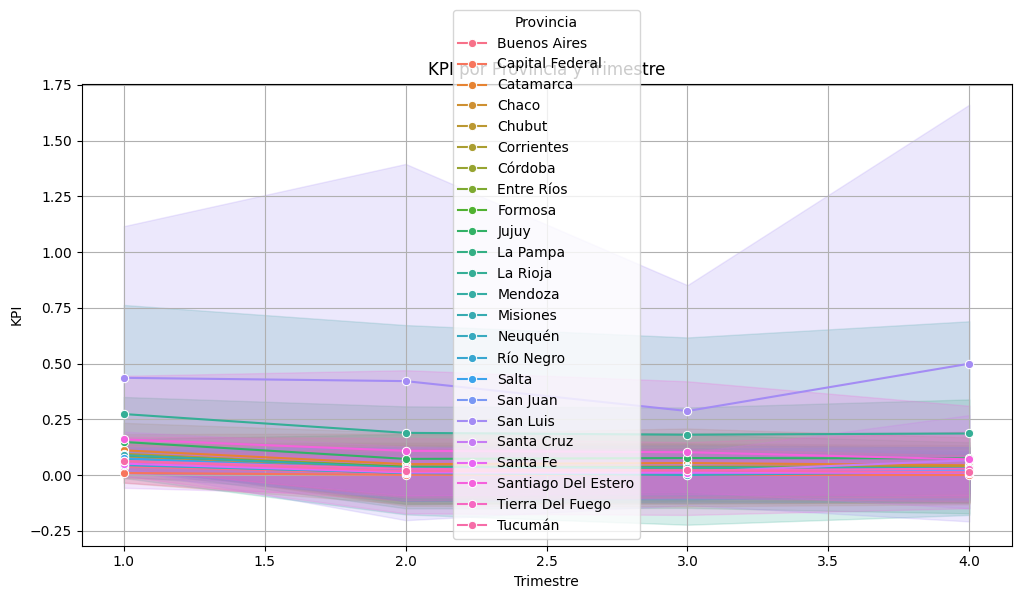

In [26]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='trimestre', y='kpi', hue='provincia', marker='o')

plt.xlabel('Trimestre')
plt.ylabel('KPI')
plt.title('KPI por Provincia y Trimestre')
plt.legend(title='Provincia')
plt.grid(True)

plt.show()

In [99]:
def plot_kpi(provincia,año):
    # Configurar el tamaño de la figura
    plt.figure(figsize=(6, 4))

    # Crear un gráfico de barras
    sns.barplot(data=df.loc[ (df['provincia']==provincia) & (df['año']==año)], x='trimestre', y='accesosPor100Hogares', hue='provincia')
    plt.axhline(y=df.loc[(df['provincia'] == provincia) & (df['año'] == año), 'meta_trimestral'].values[0], color='r', linestyle='--', label='Objetivo KPI')
    #valor_kpi = df.loc[(df['provincia'] == 'Buenos Aires') & (df['año'] == 2023), 'kpi'].values[0]
    # Añadir etiquetas y título
    plt.xlabel('Trimestre')
    plt.ylabel('KPI')
    plt.title(f'KPI por Provincia y Trimestre de {provincia}')
    plt.legend(title='Provincia')
    plt.grid(True)

    # Mostrar la gráfica
    plt.show()

In [95]:
df['provincia'].unique()

array(['Buenos Aires', 'Capital Federal', 'Catamarca', 'Chaco', 'Chubut',
       'Corrientes', 'Córdoba', 'Entre Ríos', 'Formosa', 'Jujuy',
       'La Pampa', 'La Rioja', 'Mendoza', 'Misiones', 'Neuquén',
       'Río Negro', 'Salta', 'San Juan', 'San Luis', 'Santa Cruz',
       'Santa Fe', 'Santiago Del Estero', 'Tierra Del Fuego', 'Tucumán'],
      dtype=object)

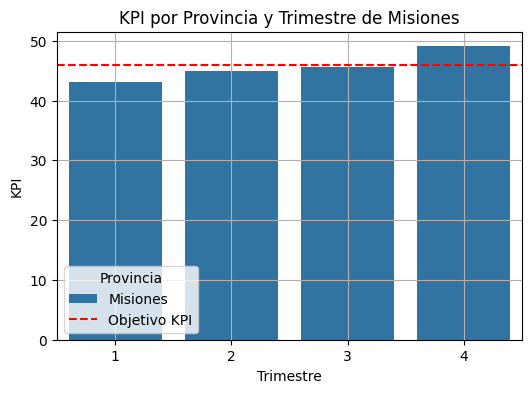

In [103]:
plot_kpi('Misiones',2021)

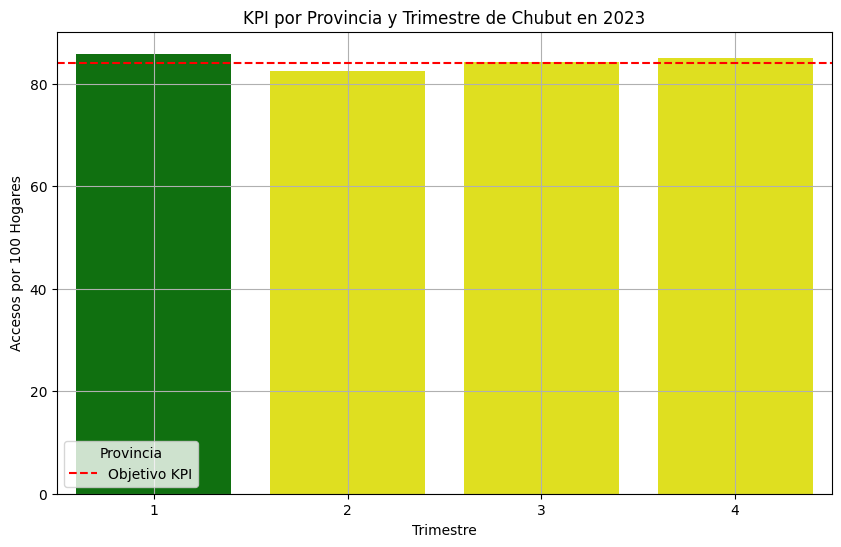

In [108]:
def plot_kpi(provincia, año):
    # Filtrar los datos para la provincia y año especificados
    df_filtered = df.loc[(df['provincia'] == provincia) & (df['año'] == año)]

    # Calcular los colores para cada barra según las condiciones
    colors = []
    for idx, row in df_filtered.iterrows():
        if row['accesosPor100Hogares'] > row['meta_trimestral']:
            colors.append('green')
        elif row['accesosPor100Hogares'] > row['accesosPor100Hogares'] / 2:
            colors.append('yellow')
        else:
            colors.append('red')

    # Configurar el tamaño de la figura
    plt.figure(figsize=(10, 6))

    # Crear un gráfico de barras con los colores personalizados
    sns.barplot(data=df_filtered, x='trimestre', y='accesosPor100Hogares', palette=colors)

    # Añadir una línea de referencia para la meta trimestral
    plt.axhline(y=df_filtered['meta_trimestral'].values[0], color='r', linestyle='--', label='Objetivo KPI')

    # Añadir etiquetas y título
    plt.xlabel('Trimestre')
    plt.ylabel('Accesos por 100 Hogares')
    plt.title(f'KPI por Provincia y Trimestre de {provincia} en {año}')
    plt.legend(title='Provincia')
    plt.grid(True)

    # Mostrar la gráfica
    plt.show()

# Usar la función para una provincia y año específicos
plot_kpi('Chubut', 2023)


# Calculo del segundo KPI

Este segundo KPI lo estoy pensando de la siguiente manera:
En el archivo de portabilidad tenemos las bajas por empresa asi que se me ocurrió que se tenga un tope del 2% de bajas por empresa de tal manera que el objetivo es NO llegar al valor limite del KPI
entre menor sea el valor es mejor.
Para esto tome ambas hojas del archivo y obtengo un dataset para la empresa claro

In [109]:
engine = fun.crear_conexion_mysql()


In [112]:
query = """select 
 a.año,a.mes,a.personal as mov_personal,a.claro as mov_claro, a.nextel as mov_nextel, a.movistar as mov_movistar,
 b.personal as in_personal,b.claro as in_claro, b.nextel as in_nextel, b.movistar as in_movistar
from internet_portabilidad a
join internet_portabilidad_in b on a.año=b.año and a.mes=b.mes
where a.año=2023; """

In [114]:
df = pd.read_sql(query, con=engine)

In [144]:
df.head(5)

,año,mes,mov_personal,mov_claro,mov_nextel,mov_movistar,in_personal,in_claro,in_nextel,in_movistar,bajas_mes_permitidas_claro
8,2023,1,2177,-2138,0,-290,55906,105125,None,104264,0.00
7,2023,2,-3935,4447,0,-757,45371,81714,None,80848,2102.50
6,2023,3,382,3067,0,-3746,62834,98316,None,92180,1634.28
5,2023,4,2392,-1225,0,-1498,49819,75864,None,69237,1966.32
4,2023,5,5643,-5225,0,-937,48835,69432,None,71340,1517.28


In [143]:
df.info()
df['bajas_mes_permitidas_claro']=df['bajas_mes_permitidas_claro'].fillna(0)

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 8 to 0
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   año                         9 non-null      int64  
 1   mes                         9 non-null      int64  
 2   mov_personal                9 non-null      int64  
 3   mov_claro                   9 non-null      int64  
 4   mov_nextel                  9 non-null      int64  
 5   mov_movistar                9 non-null      int64  
 6   in_personal                 9 non-null      int64  
 7   in_claro                    9 non-null      int64  
 8   in_nextel                   0 non-null      object 
 9   in_movistar                 9 non-null      int64  
 10  bajas_mes_permitidas_claro  8 non-null      float64
dtypes: float64(1), int64(9), object(1)
memory usage: 864.0+ bytes


In [189]:
# Ordenar el DataFrame por provincia y trimestre
df = df.sort_values(by=['año', 'mes'])

# Calcular el acceso del trimestre anterior usando shift
df['bajas_mes_permitidas_claro'] = df['in_claro'].shift(1)*.02

df_claro=df.loc[:,['año','mes','mov_claro','bajas_mes_permitidas_claro']]

In [192]:
df_claro['bajas_mes_permitidas_claro']=df_claro['bajas_mes_permitidas_claro'].fillna(0)
df_claro

,año,mes,mov_claro,bajas_mes_permitidas_claro
8,2023,1,-2138,0.00
7,2023,2,4447,2102.50
6,2023,3,3067,1634.28
5,2023,4,-1225,1966.32
4,2023,5,-5225,1517.28
3,2023,6,2607,1388.64
2,2023,7,5828,1296.58
1,2023,8,2077,1179.00
0,2023,9,1467,1209.00


In [188]:
df_claro.loc[df_claro['mov_claro'] <0]

,año,mes,mov_claro,bajas_mes_permitidas_claro
8,2023,1,-2138,NaN
5,2023,4,-1225,1966.32
4,2023,5,-5225,1517.28


In [183]:
negativos=df_claro.loc[df_claro['mov_claro']< 0.0]
negativos['bajas_mes_permitidas_claro']=negativos['bajas_mes_permitidas_claro'].fillna(0)
negativos

,año,mes,mov_claro,bajas_mes_permitidas_claro
8,2023,1,-2138,0.00
5,2023,4,-1225,1966.32
4,2023,5,-5225,1517.28


1388.64


<Figure size 600x400 with 0 Axes>

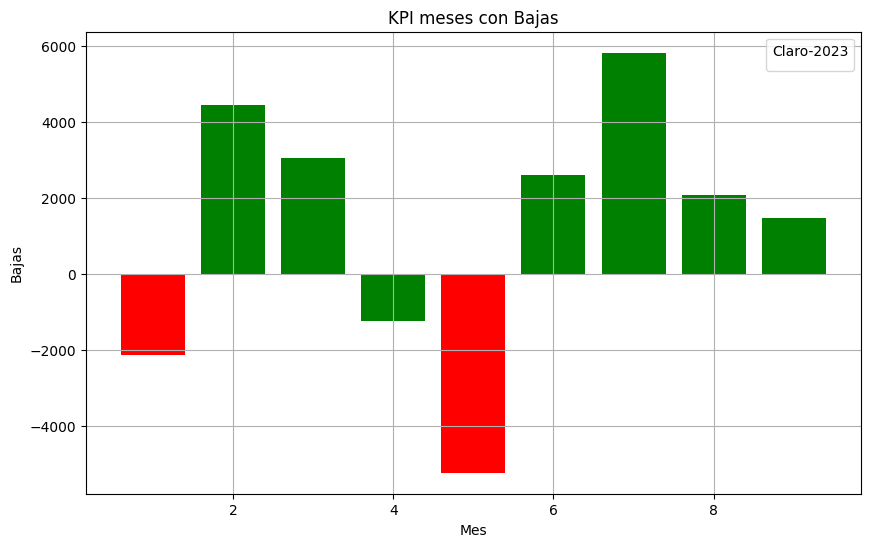

In [197]:

# Configurar el tamaño de la figura
plt.figure(figsize=(6, 4))

valor_mediana=df_claro['bajas_mes_permitidas_claro'].median()
print(valor_mediana)
colors = []
for idx, row in df_claro.iterrows():
    #print(abs(row['mov_claro']), row['bajas_mes_permitidas_claro'])
    if (row['mov_claro'] < 0.0) & (abs(row['mov_claro']) < row['bajas_mes_permitidas_claro']):
        colors.append('green')
    elif (row['mov_claro'] > 0.0) & ((row['mov_claro'] < row['bajas_mes_permitidas_claro']) | (row['mov_claro'] > row['bajas_mes_permitidas_claro'])):
        colors.append('green')
    elif (row['mov_claro'] < 0.0) & (abs(row['mov_claro']) > row['bajas_mes_permitidas_claro']):
        colors.append('red')
    
    # if abs(row['mov_claro']) < row['bajas_mes_permitidas_claro']:
    #     colors.append('green')
    # elif abs(row['mov_claro']) > row['bajas_mes_permitidas_claro']:
    #     colors.append('red')
    # else:
    #     colors.append('yellow')


plt.figure(figsize=(10, 6))
bars = plt.bar(df_claro['mes'], df_claro['mov_claro'], color=colors)

# Añadir línea de referencia (meta)
#plt.axhline(y=-valor_mediana, color='r', linestyle='--', label='Objetivo KPI')

# Añadir etiquetas y título
plt.xlabel('Mes')
plt.ylabel('Bajas')
plt.title(f'KPI meses con Bajas')
plt.legend(title='Claro-2023')
plt.grid(True)

# Mostrar la gráfica
plt.show()

# 3 Cálculo del tercer kpi 

In [138]:
fun= Funciones('conexion.env')

In [139]:
engine = fun.crear_conexion_mysql()
df = pd.read_sql_table('internet_accesos_tecnologia', con=engine)

In [100]:
df.columns

Index(['idTabla', 'año', 'trimestre', 'provincia', 'adsl', 'cableModem',
       'fibraOptica', 'wireless', 'otros', 'total'],
      dtype='object')

In [140]:
# Ordenar el DataFrame por provincia y trimestre
df = df.sort_values(by=['provincia', 'año','trimestre'])

# Calcular el acceso del trimestre anterior usando shift
df['accesos_trimestre_anterior'] = df.groupby(['provincia'])['total'].shift(1)

In [141]:
df.head(3)

,idTabla,año,trimestre,provincia,adsl,cableModem,fibraOptica,wireless,otros,total,accesos_trimestre_anterior
936,937,2014,1,Buenos Aires,1567680.0,1000880.0,120960.0,16528.0,33824.0,2739880.0,NaN
912,913,2014,2,Buenos Aires,1568880.0,1025490.0,120008.0,17020.0,33147.0,2764550.0,2739880.0
888,889,2014,3,Buenos Aires,1562530.0,1110630.0,124474.0,20049.0,31881.0,2849560.0,2764550.0


In [142]:
df['meta_trimestral']=df.groupby('provincia')['total'].apply(lambda x: (x * 1.02)).reset_index(level=0, drop=True)

In [143]:
df_accesos_tecnologia=df.copy()

In [48]:
df.loc[df['provincia']=='San Luis']

,idTabla,año,trimestre,provincia,adsl,cableModem,fibraOptica,wireless,otros,total,accesos_trimestre_anterior,meta_trimestral
954,955,2014,1,San Luis,11306.0,428.0,354.0,21.0,448.0,12557.0,NaN,12808.14
930,931,2014,2,San Luis,11306.0,925.0,354.0,22.0,448.0,13055.0,12557.0,13316.10
906,907,2014,3,San Luis,11303.0,925.0,355.0,25.0,438.0,13046.0,13055.0,13306.92
882,883,2014,4,San Luis,11419.0,926.0,355.0,24.0,423.0,13147.0,13046.0,13409.94
858,859,2015,1,San Luis,11414.0,1025.0,351.0,30.0,412.0,13232.0,13147.0,13496.64
834,835,2015,2,San Luis,11432.0,1025.0,354.0,33.0,377.0,13221.0,13232.0,13485.42
810,811,2015,3,San Luis,11432.0,1025.0,354.0,31.0,377.0,13219.0,13221.0,13483.38
786,787,2015,4,San Luis,11432.0,1025.0,354.0,30.0,377.0,13218.0,13219.0,13482.36
762,763,2016,1,San Luis,11432.0,1042.0,354.0,27.0,377.0,13232.0,13218.0,13496.64
738,739,2016,2,San Luis,11432.0,1063.0,354.0,30.0,377.0,13256.0,13232.0,13521.12


In [46]:
def kpi3(provincia,año):
    plt.figure(figsize=(6, 4))
    df_filtered = df.loc[(df['provincia'] == provincia) & (df['año'] == año)]
# valor_mediana=df_claro['bajas_mes_permitidas_claro'].median()
    print(df_filtered['meta_trimestral'])
    colors = []
    for idx, row in df_filtered.iterrows():
        #print(abs(row['mov_claro']), row['bajas_mes_permitidas_claro'])
        print(row['meta_trimestral']/3)
        if (row['total'] < (row['meta_trimestral']/3)):
            colors.append('red')
        elif (row['total'] < (2*(row['meta_trimestral']/3)) or (row['total'] > (row['meta_trimestral']/3))):
             colors.append('yellow')
        elif (row['total'] > 2*(row['meta_trimestral']/3)):
             colors.append('green')
        


    plt.figure(figsize=(10, 6))
    bars = plt.bar(df_filtered['trimestre'], df_filtered['total'], color=colors)

    # Añadir línea de referencia (meta)
    #plt.axhline(y=-valor_mediana, color='r', linestyle='--', label='Objetivo KPI')

    # Añadir etiquetas y título
    plt.xlabel('trimestre')
    plt.ylabel('Accesos por tecnología')
    plt.title(f'KPI Accesos por Tecnología')
    plt.legend(title=provincia)
    plt.grid(True)

    # Mostrar la gráfica
    plt.show()

In [38]:
df['provincia'].unique()

array(['Buenos Aires', 'Capital Federal', 'Catamarca', 'Chaco', 'Chubut',
       'Corrientes', 'Córdoba', 'Entre Ríos', 'Formosa', 'Jujuy',
       'La Pampa', 'La Rioja', 'Mendoza', 'Misiones', 'Neuquén',
       'Río Negro', 'Salta', 'San Juan', 'San Luis', 'Santa Cruz',
       'Santa Fe', 'Santiago Del Estero', 'Tierra Del Fuego', 'Tucumán'],
      dtype=object)

73    1579704.6
49    1486833.6
25    1497339.6
1     1503857.4
Name: meta_trimestral, dtype: float64
526568.2000000001
495611.2
499113.2
501285.80000000005


<Figure size 600x400 with 0 Axes>

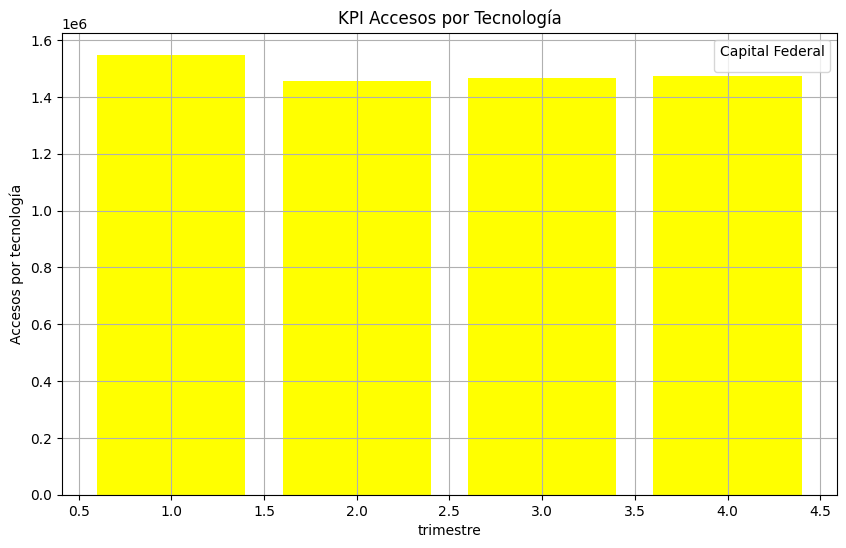

In [50]:
kpi3('Capital Federal',2023)

# Cálculo de un 4to KPI

In [144]:
fun= Funciones('conexion.env')

In [145]:
engine = fun.crear_conexion_mysql()
df = pd.read_sql_table('internet_accesos_velocidad', con=engine)

In [146]:
df.columns

Index(['idTabla', 'año', 'trimestre', 'provincia', 'hasta512', 'De512_1mbps',
       'De1_6mbps', 'De6_10mbps', 'De10_20mbps', 'De20_30mbps', 'mas30mbps',
       'otros', 'total'],
      dtype='object')

In [92]:
# Ordenar el DataFrame por provincia y trimestre
df = df.sort_values(by=['provincia', 'año','trimestre'])

# Calcular el acceso del trimestre anterior usando shift
df['accesos_trimestre_anterior'] = df.groupby(['provincia'])['mas30mbps'].shift(1)
df['accesos_trimestre_anterior'].fillna(0)
df.head(10)

,idTabla,año,trimestre,provincia,hasta512,De512_1mbps,De1_6mbps,De6_10mbps,De10_20mbps,De20_30mbps,mas30mbps,otros,total,accesos_trimestre_anterior
936,937,2014,1,Buenos Aires,8469.00,171244.0,2279880.0,121787.0,38923.3,206.16,4037.00,0.0,2624540.0,NaN
912,913,2014,2,Buenos Aires,6902.00,162274.0,2288770.0,140226.0,56548.9,284.32,4309.00,0.0,2659320.0,4037.00
888,889,2014,3,Buenos Aires,7355.00,128187.0,2281520.0,156693.0,68946.9,243.32,4232.00,0.0,2647180.0,4309.00
864,865,2014,4,Buenos Aires,8226.00,132937.0,2250450.0,203620.0,104322.0,996.96,5406.00,0.0,2705950.0,4232.00
840,841,2015,1,Buenos Aires,8882.00,123589.0,2267850.0,220070.0,126958.0,1560.64,5700.00,0.0,2754610.0,5406.00
816,817,2015,2,Buenos Aires,8714.00,137189.0,2299710.0,243503.0,159922.0,2009.68,6712.00,0.0,2857750.0,5700.00
792,793,2015,3,Buenos Aires,8361.00,107351.0,2266950.0,262564.0,200491.0,2642.32,7720.00,0.0,2856080.0,6712.00
768,769,2015,4,Buenos Aires,7984.92,100303.0,2253200.0,274560.0,240188.0,3834.52,8179.96,0.0,2888250.0,7720.00
744,745,2016,1,Buenos Aires,7350.92,97879.9,2214760.0,289929.0,247372.0,8315.00,9528.88,0.0,2875140.0,8179.96
720,721,2016,2,Buenos Aires,10786.00,133385.0,2250900.0,335296.0,334723.0,31494.00,11933.00,0.0,3108520.0,9528.88


In [147]:
df['meta_trimestral']=df.groupby('provincia')['mas30mbps'].apply(lambda x: (x * 1.01)).reset_index(level=0, drop=True)

In [148]:
df.head(20)

,idTabla,año,trimestre,provincia,hasta512,De512_1mbps,De1_6mbps,De6_10mbps,De10_20mbps,De20_30mbps,mas30mbps,otros,total,meta_trimestral
0,1,2023,4,Buenos Aires,26909.0,23962.0,228393.0,239339.0,246144.0,110876.0,4042650.0,93351.0,5011620.0,4083076.50
1,2,2023,4,Capital Federal,516.0,4544.0,26409.0,48083.0,33925.0,5829.0,1355060.0,0.0,1474370.0,1368610.60
2,3,2023,4,Catamarca,71.0,209.0,3065.0,3734.0,4423.0,1827.0,61181.0,77.0,74587.0,61792.81
3,4,2023,4,Chaco,236.0,477.0,14811.0,10361.0,6247.0,5729.0,105485.0,4040.0,147386.0,106539.85
4,5,2023,4,Chubut,111.0,1088.0,44276.0,31402.0,22843.0,20196.0,33665.0,16589.0,170170.0,34001.65
5,6,2023,4,Córdoba,99.0,8404.0,117068.0,91169.0,51126.0,26948.0,767427.0,17061.0,1079300.0,775101.27
6,7,2023,4,Corrientes,67.0,2889.0,19949.0,17984.0,8108.0,5087.0,98904.0,6484.0,159472.0,99893.04
7,8,2023,4,Entre Ríos,107.0,4408.0,37150.0,54377.0,16673.0,7236.0,164304.0,14382.0,298637.0,165947.04
8,9,2023,4,Formosa,85.0,179.0,21856.0,11563.0,4545.0,272.0,23152.0,350.0,62002.0,23383.52
9,10,2023,4,Jujuy,58.0,1343.0,15359.0,11724.0,28741.0,272.0,58543.0,1980.0,118020.0,59128.43


In [149]:
df_accesos_velocidad=df.copy()

# union de tablas para unir Kpis para el tablero

In [150]:
df_accesos_velocidad.columns

Index(['idTabla', 'año', 'trimestre', 'provincia', 'hasta512', 'De512_1mbps',
       'De1_6mbps', 'De6_10mbps', 'De10_20mbps', 'De20_30mbps', 'mas30mbps',
       'otros', 'total', 'meta_trimestral'],
      dtype='object')

In [151]:
df_penetracion_hogares=df_penetracion_hogares.loc[:,['año', 'trimestre', 'provincia', 'accesosPor100Hogares','meta_trimestral']]
df_penetracion_hogares

,año,trimestre,provincia,accesosPor100Hogares,meta_trimestral
936,2014,1,Buenos Aires,54.5701,NaN
912,2014,2,Buenos Aires,55.0614,55.661502
888,2014,3,Buenos Aires,56.7547,56.162628
864,2014,4,Buenos Aires,56.0943,57.889794
840,2015,1,Buenos Aires,56.3705,57.216186
...,...,...,...,...,...
119,2022,4,Tucumán,61.0400,62.362800
95,2023,1,Tucumán,60.3400,62.260800
71,2023,2,Tucumán,60.7500,61.546800
47,2023,3,Tucumán,61.2600,61.965000


In [152]:
df_penetracion_hogares = df_penetracion_hogares.rename(columns={
    'año': 'año',
    'trimestre': 'trimestre',
    'provincia': 'provincia',
    'accesosPor100Hogares': 'h_accesosPor100Hogares',
    'meta_trimestral':'h_meta_trimestral'
})


In [153]:

df_accesos_tecnologia=df_accesos_tecnologia.loc[:,['año', 'trimestre', 'provincia', 'total','meta_trimestral']]
df_accesos_tecnologia

,año,trimestre,provincia,total,meta_trimestral
936,2014,1,Buenos Aires,2739880.0,2794677.60
912,2014,2,Buenos Aires,2764550.0,2819841.00
888,2014,3,Buenos Aires,2849560.0,2906551.20
864,2014,4,Buenos Aires,2816410.0,2872738.20
840,2015,1,Buenos Aires,2861840.0,2919076.80
...,...,...,...,...,...
119,2022,4,Tucumán,263422.0,268690.44
95,2023,1,Tucumán,261100.0,266322.00
71,2023,2,Tucumán,263602.0,268874.04
47,2023,3,Tucumán,266557.0,271888.14


In [154]:
df_accesos_tecnologia = df_accesos_tecnologia.rename(columns={
    'año': 'año',
    'trimestre': 'trimestre',
    'provincia': 'provincia',
    'total': 'at_total',
    'meta_trimestral':'at_meta_trimestral'
})

In [155]:

df_accesos_velocidad=df_accesos_velocidad.loc[:,['año', 'trimestre', 'provincia', 'mas30mbps','meta_trimestral','total']]
df_accesos_velocidad

,año,trimestre,provincia,mas30mbps,meta_trimestral,total
0,2023,4,Buenos Aires,4042650.0,4083076.50,5011620.0
1,2023,4,Capital Federal,1355060.0,1368610.60,1474370.0
2,2023,4,Catamarca,61181.0,61792.81,74587.0
3,2023,4,Chaco,105485.0,106539.85,147386.0
4,2023,4,Chubut,33665.0,34001.65,170170.0
...,...,...,...,...,...,...
955,2014,1,Santa Cruz,0.0,0.00,26760.0
956,2014,1,Santa Fe,668.0,674.68,506013.0
957,2014,1,Santiago Del Estero,0.0,0.00,37113.0
958,2014,1,Tierra Del Fuego,0.0,0.00,31527.0


In [156]:
df_accesos_velocidad = df_accesos_velocidad.rename(columns={
    'año': 'año',
    'trimestre': 'trimestre',
    'provincia': 'provincia',
    'total': 'v_total',
    'meta_trimestral':'v_meta_trimestral'
})



In [157]:
df_aux= pd.merge(df_penetracion_hogares, df_accesos_tecnologia, on=['provincia', 'año', 'trimestre'])
df_aux

,año,trimestre,provincia,h_accesosPor100Hogares,h_meta_trimestral,at_total,at_meta_trimestral
0,2014,1,Buenos Aires,54.5701,NaN,2739880.0,2794677.60
1,2014,2,Buenos Aires,55.0614,55.661502,2764550.0,2819841.00
2,2014,3,Buenos Aires,56.7547,56.162628,2849560.0,2906551.20
3,2014,4,Buenos Aires,56.0943,57.889794,2816410.0,2872738.20
4,2015,1,Buenos Aires,56.3705,57.216186,2861840.0,2919076.80
...,...,...,...,...,...,...,...
955,2022,4,Tucumán,61.0400,62.362800,263422.0,268690.44
956,2023,1,Tucumán,60.3400,62.260800,261100.0,266322.00
957,2023,2,Tucumán,60.7500,61.546800,263602.0,268874.04
958,2023,3,Tucumán,61.2600,61.965000,266557.0,271888.14


In [158]:
df_merge=pd.merge(df_aux, df_accesos_velocidad, on=['provincia', 'año', 'trimestre'])

In [159]:
df_merge

,año,trimestre,provincia,h_accesosPor100Hogares,h_meta_trimestral,at_total,at_meta_trimestral,mas30mbps,v_meta_trimestral,v_total
0,2014,1,Buenos Aires,54.5701,NaN,2739880.0,2794677.60,4037.0,4077.37,2624540.0
1,2014,2,Buenos Aires,55.0614,55.661502,2764550.0,2819841.00,4309.0,4352.09,2659320.0
2,2014,3,Buenos Aires,56.7547,56.162628,2849560.0,2906551.20,4232.0,4274.32,2647180.0
3,2014,4,Buenos Aires,56.0943,57.889794,2816410.0,2872738.20,5406.0,5460.06,2705950.0
4,2015,1,Buenos Aires,56.3705,57.216186,2861840.0,2919076.80,5700.0,5757.00,2754610.0
...,...,...,...,...,...,...,...,...,...,...
955,2022,4,Tucumán,61.0400,62.362800,263422.0,268690.44,153538.0,155073.38,263422.0
956,2023,1,Tucumán,60.3400,62.260800,261100.0,266322.00,164402.0,166046.02,261100.0
957,2023,2,Tucumán,60.7500,61.546800,263602.0,268874.04,185887.0,187745.87,263602.0
958,2023,3,Tucumán,61.2600,61.965000,266557.0,271888.14,192051.0,193971.51,266557.0


In [161]:
def crear_conexion_mysql():
    load_dotenv('conexion.env')
    # Leer variables de entorno
    username = os.getenv('DB_USERNAME')
    password = os.getenv('DB_PASSWORD')
    hostname = os.getenv('DB_HOST')
    dbname = os.getenv('DB_NAME')
    # Crear la conexión a la base de datos
    engine = create_engine(f'mysql+mysqlconnector://{username}:{password}@{hostname}/{dbname}')
    return engine

In [162]:
engine = crear_conexion_mysql()

In [164]:
#Crear un objeto MetaData
metadata = MetaData()

In [165]:
# Definir la estructura de la tabla df_acceso_por_velocidad
tabla = Table(
    'internet_kpi_merge', metadata,
    Column('idTabla', Integer, primary_key=True,autoincrement="auto" ),
    Column('año', Integer, nullable=False),
    Column('trimestre', Integer,nullable=False),
    Column('provincia', String(50)),
    Column('h_accesosPor100Hogares', Float),
    Column('h_meta_trimestral', Float),
    Column('at_total', Float),
    Column('at_meta_trimestral', Float),
    Column('mas30mbps',Float),
    Column('v_meta_trimestral', Float),
    Column('v_total', Float),
)

In [166]:
metadata.create_all(engine)

In [168]:
df_merge.fillna(0)

,año,trimestre,provincia,h_accesosPor100Hogares,h_meta_trimestral,at_total,at_meta_trimestral,mas30mbps,v_meta_trimestral,v_total
0,2014,1,Buenos Aires,54.5701,0.000000,2739880.0,2794677.60,4037.0,4077.37,2624540.0
1,2014,2,Buenos Aires,55.0614,55.661502,2764550.0,2819841.00,4309.0,4352.09,2659320.0
2,2014,3,Buenos Aires,56.7547,56.162628,2849560.0,2906551.20,4232.0,4274.32,2647180.0
3,2014,4,Buenos Aires,56.0943,57.889794,2816410.0,2872738.20,5406.0,5460.06,2705950.0
4,2015,1,Buenos Aires,56.3705,57.216186,2861840.0,2919076.80,5700.0,5757.00,2754610.0
...,...,...,...,...,...,...,...,...,...,...
955,2022,4,Tucumán,61.0400,62.362800,263422.0,268690.44,153538.0,155073.38,263422.0
956,2023,1,Tucumán,60.3400,62.260800,261100.0,266322.00,164402.0,166046.02,261100.0
957,2023,2,Tucumán,60.7500,61.546800,263602.0,268874.04,185887.0,187745.87,263602.0
958,2023,3,Tucumán,61.2600,61.965000,266557.0,271888.14,192051.0,193971.51,266557.0


In [170]:
# Nombre de la tabla en la base de datos
tablename = 'internet_kpi_merge'
# Subir el DataFrame a la base de datos
df_merge.to_sql(tablename, con=engine, if_exists='append', index=False)

960